# User Identification from Walking Activity

In this problem, I am going to identify the user from the motion pattern of their walking activity.

In [1]:
import os
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Dataset 
Accelerometer data (x,y,z) collected from 22 participants walking in the wild over a predefined path (i.e., 22 times series of unequal sizes): https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity

Let's look at the one of the participants:

In [2]:
path = os.getcwd()+'/users/'
user1_df = pd.read_csv(path+"1.csv", header=None)
user1_df.columns = ['time-step','x','y','z']
user1_df.head()

,time-step,x,y,z
0,0.000000,0.69464,3.17350,7.5048
1,0.030639,0.14982,3.48680,9.2755
2,0.069763,-0.29965,1.94770,9.1120
3,0.099823,-1.68890,1.41650,10.1200
4,0.129820,-2.17930,0.95342,10.9240


## Method
For this problem, I used **K-Nearest-Neighbors** as follows:

For each user, I randomly retrieve M (e.g., 10) equal sized segments of the user’s time series. A segment = one-tenth of the time that the user took to walk the path. For instance, if a user needs 154 minutes to walk the path, then we will retrieve segments of 15.4 minutes from the time series.

Also, I convert the users’ segments to features vectors. I use mean and standard deviation of accelerations in each of three dimensions, as features. Therefore, a sample has a label (user#) and a feature vector with 6 features. In total, I collect M*22 data samples (220 samples).

In [3]:
# Retrieve 10 (i.e., nsp) samples for each users and save in samples_df
# A sample is a random duration (i.e., [a, b]) of a user's walking activity.
# Duration (i.e., d) = one-tenth of the time that the user took to walk the path
#
samples_df = pd.DataFrame(columns=['user','x_mean','y_mean','z_mean','x_std','y_std','z_std'])
samples_count = 0
n_users = 22
nsp = 10 # number of samples per user
random.seed(3)
for i in range(1,n_users+1):
    df = pd.read_csv(path+str(i)+".csv", header=None)
    df.columns = ['time-step','x','y','z']
    nsamples = df.shape[0]
    d = df.tail(1).iloc[0,0]/10.0
    count = 0
    while (count < nsp):
         a = random.randint(0, nsamples)
         to_time = df.loc[a,'time-step'] + d
         if (to_time <= df.tail(1).iloc[0,0]):
            b = df[df['time-step']>=to_time].index[0]
            segment = df[a:b+1]
            s = [i,
                 segment['x'].mean(), segment['y'].mean(), segment['z'].mean(),
                 segment['x'].std(), segment['y'].std(), segment['z'].std()]
            samples_df.loc[samples_count] = s
            samples_count = samples_count + 1
            count = count + 1
samples_df.to_csv(path+"samples.csv", index=None)

Let's look at the retrieved segments:

In [4]:
samples_df.head()

,user,x_mean,y_mean,z_mean,x_std,y_std,z_std
0,1.0,-4.040429,8.775378,-1.555742,2.199474,3.035572,1.746394
1,1.0,-2.446141,7.927374,0.330240,2.975964,2.401700,4.288818
2,1.0,-4.076140,8.795578,-1.514455,2.286083,3.038374,1.800439
3,1.0,-4.508972,8.587025,-1.581713,2.234140,2.972619,1.638934
4,1.0,-4.321950,8.657268,-1.596341,2.339181,3.266040,1.740649


In [5]:
samples_df.shape[0]

220

To get a sense how the extracted features are useful, some 2D visualizations of samples for four random users shown below.

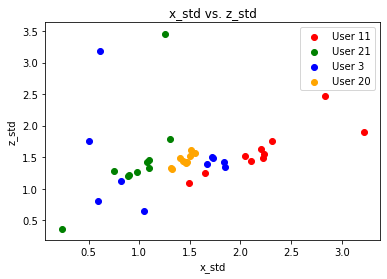

In [6]:
users = random.sample(range(1,23), 4)
ulabels = [("User "+ str(users[i])) for i in range(0,4)]
colors = ("red", "green", "blue", "orange")
for user, color in zip(users, colors):
    xdata = samples_df[samples_df['user']==user]['x_std']
    ydata = samples_df[samples_df['user']==user]['z_std']
    plt.scatter(x=xdata, y=ydata, color=color)
plt.xlabel("x_std")
plt.ylabel("z_std")
plt.title("x_std vs. z_std")
plt.legend(labels=ulabels)
plt.show()

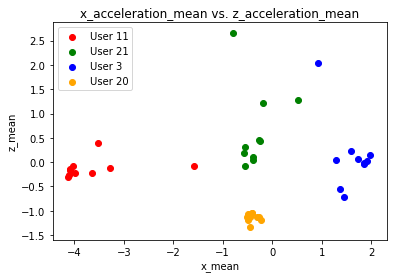

In [7]:
for user, color in zip(users, colors):
    xdata = samples_df[samples_df['user']==user]['x_mean']
    ydata = samples_df[samples_df['user']==user]['z_mean']
    plt.scatter(x=xdata, y=ydata, color=color)
plt.xlabel("x_mean")
plt.ylabel("z_mean")
plt.title("x_acceleration_mean vs. z_acceleration_mean")
plt.legend(labels=ulabels)
plt.show()

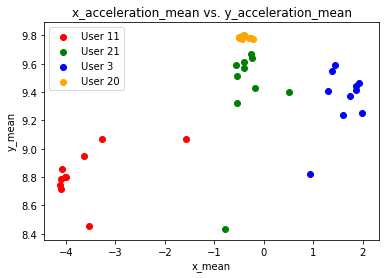

In [8]:
for user, color in zip(users, colors):
    xdata = samples_df[samples_df['user']==user]['x_mean']
    ydata = samples_df[samples_df['user']==user]['y_mean']
    plt.scatter(x=xdata, y=ydata, color=color)
plt.xlabel("x_mean")
plt.ylabel("y_mean")
plt.title("x_acceleration_mean vs. y_acceleration_mean")
plt.legend(labels=ulabels)
plt.show()

We can visually recognize users' clusters in the above graphs. This indicates the usefulness of our extracted features.

Now, I split the samples into train (80%) and test (20%) data.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(samples_df.iloc[:,1:7], samples_df.iloc[:,0], test_size=0.20, random_state=3)

Then, I train a KNN (with k=3) with the training samples.

In [10]:
myKNN = KNeighborsClassifier(n_neighbors = 3)
myKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Let's see how our KNN classifier performs on the test data, given the current random number generator setting.

In [11]:
success_rate = np.count_nonzero(myKNN.predict(X_test) == y_test.values)/float(y_test.shape[0])
print('this_success_rate = %5.2f percent'%(success_rate*100))

this_success_rate = 75.00 percent


Okay, this sucess rate is not bad at all. However, it is good to think for any possible improvement using the same method.

## How to improve this method?

1- To get a more reliable accuracy, we can repeat the process several times with different random seeds. The average of the success rates can be used as performance measure.

2- It looks that KNN with k=3 gives promising results for this problem. However, we also can use cross-validation to tune the parameter k.

3- We can change the definition of the segments for each user (i.e., increase or decrease the duration).

4- We can add other features to feature vectors.

5- We can use segments of time series directly in KNN (versus converting the segments to feature vectors).

## What business values are there in such data sets?

1- Recognizing if a phone has been stolen by a change in the walking pattern of the owner.

2- Using running/walking patterns to improve AI-based rehabilitation for disabled persons on different surfaces.

3- Categorizing gait disorders as a guide for therapeutic interventions (see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5318488/).

## What would you like to see added as data points to create more value?
Information about users’ gender and age.